In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

Mounted at /content/drive


## shp 파일 시각화

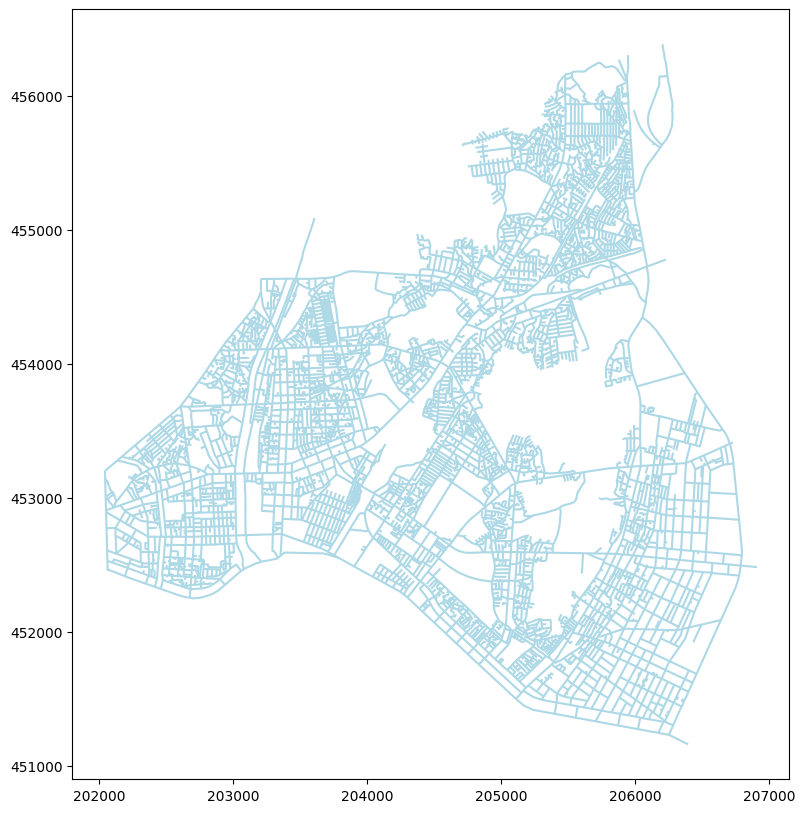

In [2]:
# Shapefile 읽기
dir_path ="/content/drive/MyDrive/2024-02-machine-learning/data/geolocation_data"
file_name = "TL_SPRD_MANAGE.shp"
dongdaemun_map = gpd.read_file(f"{dir_path}/{file_name}")

# Shapefile에서 동대문구 필터링
filtered_map = dongdaemun_map[dongdaemun_map['SIG_CD'] == '11230']

# 데이터 시각화
fig, ax = plt.subplots(figsize=(10, 10))
filtered_map.plot(ax=ax, edgecolor='black', color='lightblue')
plt.show()

## 불법주정차 시각화

In [3]:
# 불법주정차단속 위치정보 읽기
dir_path = "/content/drive/MyDrive/bigdata/dataset"
file_name = "불법주정차단속 위치정보.csv"
illegal_parking = pd.read_csv(f"{dir_path}/{file_name}")

In [4]:
illegal_parking.head()

,단속일,단속시간,구주소,도로명,경도,위도
0,20230601,00:00:00,서울 강동구 둔촌동 515,NaN,127.137312,37.529877
1,20230601,00:00:00,서울 광진구 중곡동 267-4,NaN,127.078921,37.565782
2,20230601,00:00:00,서울 용산구 갈월동 69-3,서울 용산구 한강대로 297 (갈월동),126.971684,37.544758
3,20230601,00:00:00,서울 구로구 오류동 165-3,서울 구로구 서해안로24길 21-4 (오류동),126.839413,37.489524
4,20230601,00:00:00,서울 영등포구 여의도동 27-1,서울 영등포구 의사당대로 88 (여의도동),126.922273,37.522085


In [5]:
illegal_parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774375 entries, 0 to 774374
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   단속일     774375 non-null  int64  
 1   단속시간    774375 non-null  object 
 2   구주소     772797 non-null  object 
 3   도로명     700391 non-null  object 
 4   경도      774228 non-null  float64
 5   위도      774228 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 35.4+ MB


In [6]:
# 구주소 칼럼에서 "서울 동대문구"를 포함한 데이터 필터링
illegal_parking = illegal_parking[illegal_parking['구주소'].str.contains('서울 동대문구', na=False)]

# '단속일'이 20230601 ~ 20230630 범위에 속하는 데이터 필터링
illegal_parking = illegal_parking[(illegal_parking['단속일'] >= 20230601) & (illegal_parking['단속일'] <= 20230630)]

# 필요한 칼럼만 선택하고 칼럼 이름 변경
illegal_parking = illegal_parking[['구주소', '도로명', '경도', '위도']].rename(columns={'경도': 'x', '위도': 'y'})

illegal_parking.head()

,구주소,도로명,x,y
153,서울 동대문구 전농동 222-5,서울 동대문구 서울시립대로12길 47 (전농동),127.052290,37.577781
156,서울 동대문구 답십리동 484-29,서울 동대문구 황물로 113 (답십리동),127.051994,37.568943
291,서울 동대문구 신설동 89-79,서울 동대문구 왕산로 25 (신설동),127.026127,37.576822
334,서울 동대문구 답십리동 1-336,서울 동대문구 한천로 169,127.067170,37.576145
335,서울 동대문구 장안동 125-10,서울 동대문구 한천로36길 5,127.068027,37.575926


In [7]:
# '구주소' 기준으로 데이터의 개수를 세고, 3번 이상 중복된 데이터만 필터링
frequent_addresses = illegal_parking.groupby('구주소').filter(lambda x: len(x) >= 3)
frequent_addresses = frequent_addresses.drop_duplicates()

# 결과 확인
frequent_addresses.head()
print(len(frequent_addresses))


1623


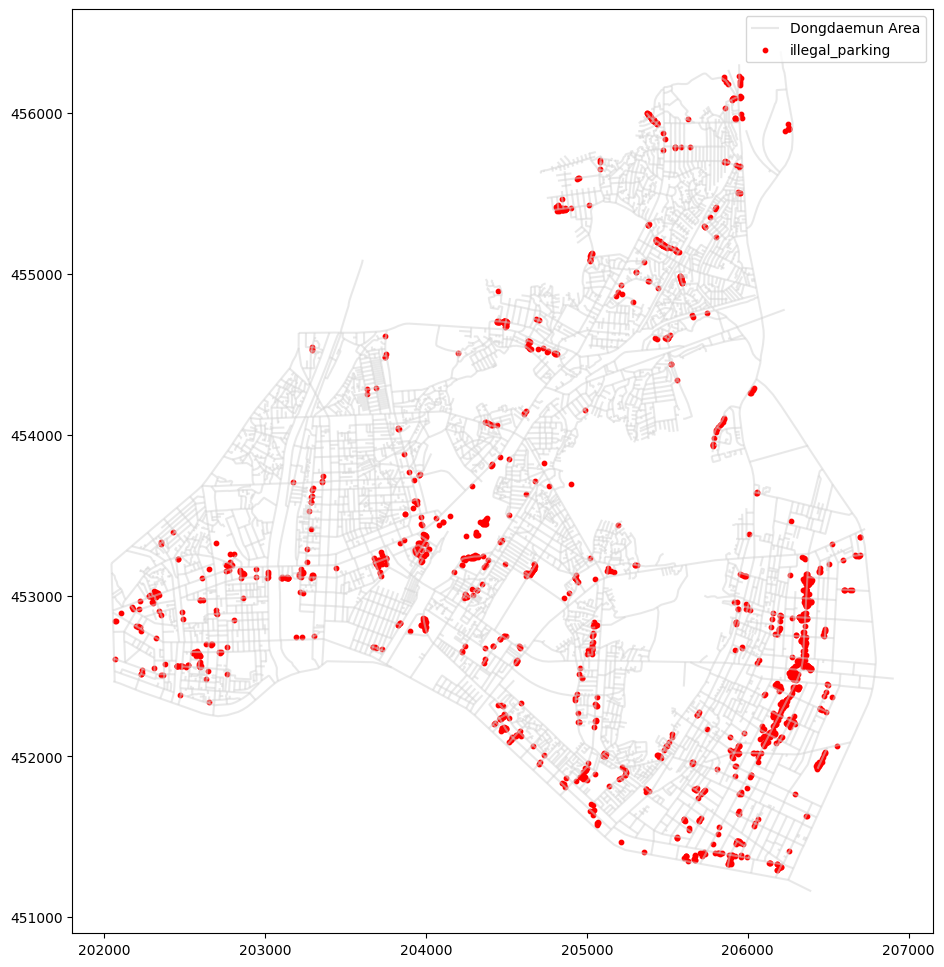

In [8]:
# 단란주점 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(frequent_addresses['x'], frequent_addresses['y'])]
frequent_addresses_geo = gpd.GeoDataFrame(frequent_addresses, geometry=geometry, crs="EPSG:4326")

# 유흥주점 데이터를 Shapefile 좌표계(EPSG:5181)로 변환
frequent_addresses_geo = frequent_addresses_geo.to_crs(filtered_map.crs)

# 동대문구 지도와 유흥주점 데이터를 함께 시각화
fig, ax = plt.subplots(figsize=(12, 12))
filtered_map.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Dongdaemun Area')
frequent_addresses_geo.plot(ax=ax, color='red', markersize=10, label='illegal_parking')
plt.legend()
plt.show()

In [9]:
output_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료/상습불법주정차위치.csv"
frequent_addresses.to_csv(output_path, index=False, encoding='utf-8-sig')